## Velocity-conditional diffusion model training on monkey data
This notebook trains a LDNS diffusion model conditioned on behavior velocity traces. It follows the same training procedure as the unconditional diffusion model, but with the addition of velocity channels that are given as input to the denoiser. Finally, it plots trajectories that are decoded from spikes that are conditionally generated based on test velocity traces.

In [1]:
%load_ext autoreload
%autoreload 2

# append parent directory to path (../notebooks -> ..)
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

import accelerate
import lovely_tensors as lt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import yaml
from diffusers.optimization import get_scheduler
from omegaconf import OmegaConf
from tqdm.auto import tqdm

from ldns.networks import AutoEncoder, CountWrapper
from ldns.utils.plotting_utils import *
from ldns.networks import Denoiser
from diffusers.training_utils import EMAModel
from diffusers.schedulers import DDPMScheduler

lt.monkey_patch()
matplotlib.rc_file("matplotlibrc")  # mackelab plotting style


In [2]:
## load config and model path

cfg_ae = OmegaConf.load("conf/autoencoder-monkey_z=16.yaml")

cfg_yaml = """
denoiser_model:
  C_in: 16
  C: 256
  num_blocks: 6
  bidirectional: True
  num_train_timesteps: 1000
training:
  lr: 0.001
  weight_decay: 0.0
  num_epochs: 2000
  num_warmup_epochs: 50
  batch_size: 512
  random_seed: 42
  precision: "no"
exp_name: diffusion_monkey_velocity_conditioned
"""

cfg = OmegaConf.create(yaml.safe_load(cfg_yaml))
cfg.dataset = cfg_ae.dataset


### Load autoencoder (with checkpoint) and autoencoder dataset


In [3]:
from ldns.data.monkey import get_monkey_dataloaders

# initialize autoencoder model
ae_model = AutoEncoder(
    C_in=cfg_ae.model.C_in,
    C=cfg_ae.model.C,
    C_latent=cfg_ae.model.C_latent,
    L=cfg_ae.dataset.signal_length,
    num_blocks=cfg_ae.model.num_blocks,
    num_blocks_decoder=cfg_ae.model.get("num_blocks_decoder", cfg_ae.model.num_blocks),
    num_lin_per_mlp=cfg_ae.model.get("num_lin_per_mlp", 2),  # default 2
    bidirectional=cfg_ae.model.get("bidirectional", True),
)

ae_model = CountWrapper(ae_model)

# load pretrained autoencoder
ae_model.load_state_dict(torch.load(f"exp/stored_models/{cfg_ae.exp_name}/model.pt"))

# set random seeds
torch.manual_seed(cfg.training.random_seed)
np.random.seed(cfg.training.random_seed)

# get dataloaders
train_dataloader, val_dataloader, test_dataloader = get_monkey_dataloaders(
    cfg_ae.dataset.task, cfg_ae.dataset.datapath, bin_width=5, batch_size=cfg_ae.training.batch_size
)

# setup accelerator
accelerator = accelerate.Accelerator(
    mixed_precision=cfg_ae.training.get("precision", "no"),
)

# prepare model and data for training
ae_model = accelerator.prepare(ae_model)

(
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    train_dataloader,
    val_dataloader,
    test_dataloader,
)


/tmp/ipykernel_172131/637646851.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae_model.load_state_dict(torch.load(f"exp/stored_models/{cfg_ae.exp_name}/model.pt"))


Loaded train data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_train_split_5.pkl
Loaded val data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_val_split_5.pkl
Loaded train data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_train_split_5.pkl
Loaded val data dict from data/000128/sub-Jenkins/monkey_mc_maze_data_dict_val_split_5.pkl
Task: mc_maze, Bin width: 5 ms
Train: 2008, Val: 71, Test: 216


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [4]:
save_path = f"exp/{cfg.exp_name}"
os.makedirs(save_path, exist_ok=True)

In [5]:
(
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    train_dataloader,
    val_dataloader,
    test_dataloader,
)

In [6]:
# Create dataset containing behavior, behavior angle, spike dataset, latents from ae

from ldns.data.monkey import LatentMonkeyDataset

latent_dataset_train = LatentMonkeyDataset(train_dataloader, ae_model, clip=False)

latent_dataset_val = LatentMonkeyDataset(
    val_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
    clip=False,
)

latent_dataset_test = LatentMonkeyDataset(
    test_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means,
    latent_stds=latent_dataset_train.latent_stds,
    clip=False,
)

Creating latent dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Creating latent dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Creating latent dataset:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
# set up dataloaders for diffusion training

train_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_train,
    batch_size=cfg.training.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_val,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

test_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_test,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

num_batches = len(train_latent_dataloader)

# check if signal length is power of 2
if cfg.dataset.signal_length & (cfg.dataset.signal_length - 1) != 0:
    cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x

# prepare the denoiser model and dataset
(
    train_latent_dataloader,
    val_latent_dataloader,
    test_latent_dataloader,
) = accelerator.prepare(
    train_latent_dataloader,
    val_latent_dataloader,
    test_latent_dataloader,
)


In [8]:
## initialize (unconditional) denoiser

denoiser = Denoiser(
    C_in=cfg.denoiser_model.C_in + 2,  # add 2 for behavior velocity
    C=cfg.denoiser_model.C,
    L=cfg.dataset.signal_length,
    num_blocks=cfg.denoiser_model.num_blocks,
    bidirectional=cfg.denoiser_model.get("bidirectional", True),
)

# initial values may be way off, scaling down the output layer makes training faster
denoiser.conv_out.weight.data = denoiser.conv_out.weight.data * 0.1
denoiser.conv_out.bias.data = denoiser.conv_out.bias.data * 0.1

scheduler = DDPMScheduler(
    num_train_timesteps=cfg.denoiser_model.num_train_timesteps, clip_sample=False, beta_schedule="linear"
)

optimizer = torch.optim.AdamW(denoiser.parameters(), lr=cfg.training.lr)  # default wd=0.01 for now


num_batches = len(train_latent_dataloader)
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=num_batches * cfg.training.num_warmup_epochs,  # warmup for 10% of epochs
    num_training_steps=num_batches
    * cfg.training.num_epochs
    * 1.3,  # total number of steps until 0 lr, we use 1.3 to no go all the way to 0 lr
)

# prepare the denoiser model and dataset
(
    denoiser,
    optimizer,
    lr_scheduler,
) = accelerator.prepare(
    denoiser,
    optimizer,
    lr_scheduler,
)

ema_model = EMAModel(denoiser)

In [9]:
from ldns.utils import count_parameters

print(count_parameters(denoiser) / 1e6, "M parameters")


denoiser

2.701202 M parameters


Denoiser(
  (conv_in): Conv1d(18, 256, kernel_size=(1,), stride=(1,))
  (blocks): ModuleList(
    (0-5): 6 x DenoiserBlock(
      (time_mixer): FFTConv(
        (activation): Identity()
        (kernel): SSMKernelDPLR()
        (drop): Identity()
        (drop_kernel): Identity()
      )
      (channel_mixer): Sequential(
        (0): Rearrange('b c l -> b l c')
        (1): Linear(in_features=256, out_features=512, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Rearrange('b l c -> b c l')
      )
      (norm1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (norm2): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (act1): GELU(approximate='none')
      (act2): Identity()
      (ada_ln): Sequential(
        (0): GELU(approximate='none')
        (1): Linear(in_features=64, out_features=1536, bias=True)
      )
    )
  )


In [10]:
from einops import rearrange, repeat


def sample_with_velocity(
    ema_denoiser,
    scheduler,
    cfg,
    behavior_vel,
    batch_size=1,
    generator=None,
    device="cuda",
    signal_length=None,
):
    """Sample latent trajectories conditioned on velocity using DDPM.

    Args:
        ema_denoiser: exponential moving average denoiser model
        scheduler: diffusion scheduler
        cfg: config object
        behavior_vel: velocity conditioning tensor [B, 2, L]
        batch_size: number of samples to generate
        generator: random number generator
        device: device to run sampling on
        signal_length: length of signal to generate, defaults to cfg.dataset.signal_length

    Returns:
        sampled latent trajectories tensor [B, C, L]
    """
    if signal_length is None:
        signal_length = cfg.dataset.signal_length

    # validate input shapes
    assert behavior_vel.shape[0] == batch_size, "Velocity shape should be [B 2 L], B should match batch size"
    assert behavior_vel.shape[1] == 2, "Velocity shape should be [B 2 L], 2 for x and y velocity"
    assert behavior_vel.shape[2] == signal_length, "Velocity shape should be [B 2 L], L should match signal length"

    behavior_vel = behavior_vel.to(device)

    # initialize random noise
    z_t = torch.randn((batch_size, cfg.denoiser_model.C_in, signal_length)).to(device)

    # get averaged model from EMA
    ema_denoiser_avg = ema_denoiser.averaged_model
    ema_denoiser_avg.eval()

    scheduler.set_timesteps(cfg.denoiser_model.num_train_timesteps)

    # iteratively denoise
    for t in tqdm(scheduler.timesteps, desc="Sampling DDPM"):
        with torch.no_grad():
            # predict noise and remove velocity channels
            model_output = ema_denoiser_avg(
                torch.cat([z_t, behavior_vel], dim=1),
                torch.tensor([t] * batch_size).to(device).long(),
            )
            model_output = model_output[:, :-2]

        # denoise one step
        z_t = scheduler.step(model_output, t, z_t, generator=generator, return_dict=False)[0]

    return z_t


def sample_multiple_with_velocity(
    ema_denoiser,
    scheduler,
    cfg,
    behavior_vel,
    batch_size=1,
    num_samples_per_batch=1,
    generator=None,
    device="cuda",
    signal_length=None,
):
    """Sample multiple latent trajectories conditioned on velocity using DDPM.

    Args:
        ema_denoiser: exponential moving average denoiser model
        scheduler: diffusion scheduler
        cfg: config object
        behavior_vel: velocity conditioning tensor [B, 2, L]
        batch_size: number of samples to generate
        num_samples_per_batch: number of samples to generate per batch
        generator: random number generator
        device: device to run sampling on
        signal_length: length of signal to generate, defaults to cfg.dataset.signal_length

    Returns:
        sampled latent trajectories tensor [S, B, C, L] where S is num_samples_per_batch
    """
    # Repeat behavior velocity for each sample
    behavior_vel = repeat(behavior_vel, "B C L -> (S B) C L", S=num_samples_per_batch)

    # Sample with expanded batch size
    z_t = sample_with_velocity(
        ema_denoiser,
        scheduler,
        cfg,
        behavior_vel,
        batch_size=batch_size * num_samples_per_batch,
        generator=generator,
        device=device,
        signal_length=signal_length,
    )

    # Reshape output to separate samples dimension
    z_t = rearrange(z_t, "(S B) C L -> S B C L", S=num_samples_per_batch)

    return z_t

## Training loop

In [ ]:
# loss function - smooth L1 loss for better convergence than MSE
loss_fn = torch.nn.SmoothL1Loss(beta=0.05, reduction="mean")

# evaluation flags
EVAL_RATE_PLOTS = True  # plot sampled vs real rates

pbar = tqdm(range(0, cfg.training.num_epochs), desc="epochs")
for epoch in pbar:
    # training loop
    for i, batch in enumerate(train_latent_dataloader):
        denoiser.train()
        optimizer.zero_grad()

        # get latents and behavior from batch
        z = batch["latent"]
        behavior_vel = batch["behavior"]

        # sample random timesteps
        t = torch.randint(0, cfg.denoiser_model.num_train_timesteps, (z.shape[0],), device="cpu").long()

        # add noise to latents according to timestep
        noise = torch.randn_like(z)
        noisy_z = scheduler.add_noise(z, noise, t)

        # predict noise and remove behavior channels
        noise_pred = denoiser(torch.cat([noisy_z, behavior_vel], dim=1), t)
        noise_pred = noise_pred[:, :-2]  # remove behavior channels, these are useless in output

        # compute loss
        loss = loss_fn(noise, noise_pred)

        # optimization step
        accelerator.backward(loss)
        accelerator.clip_grad_norm_(denoiser.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()

        # update progress bar
        if i % 10 == 0:
            pbar.set_postfix({"loss": loss.item(), "lr": lr_scheduler.get_last_lr()[0]})

        # update EMA model
        ema_model.step(denoiser)

    # evaluation and checkpointing
    if (epoch) % 100 == 0:
        denoiser.eval()

        # sample latents conditioned on behavior
        sampled_latents = sample_with_velocity(
            ema_denoiser=ema_model,
            scheduler=scheduler,
            cfg=cfg,
            behavior_vel=latent_dataset_train.behavior[:2],
            batch_size=2,
            device="cuda",
        )
        # unnormalize latents
        sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
            sampled_latents.device
        ) + latent_dataset_train.latent_means.to(sampled_latents.device)

        # get real latents for comparison
        real_latents = latent_dataset_train.latents[:2].cuda()
        real_latents = real_latents * latent_dataset_train.latent_stds.to(
            real_latents.device
        ) + latent_dataset_train.latent_means.to(real_latents.device)

        # decode latents to rates
        with torch.no_grad():
            sampled_rates = ae_model.decode(sampled_latents).cpu()
            decoded_rates_from_real_latents = ae_model.decode(real_latents).cpu()

        # plot sampled vs real rates
        fig, ax = plt.subplots(1, 2, figsize=cm2inch(12, 4))
        im = ax[0].imshow(sampled_rates[0], aspect="auto")
        ax[0].set_title("sampled rates")
        fig.colorbar(im, ax=ax[0], orientation="vertical", fraction=0.046, pad=0.04)

        im = ax[1].imshow(decoded_rates_from_real_latents[0], aspect="auto")
        ax[1].set_title("real rates")
        fig.colorbar(im, ax=ax[1], orientation="vertical", fraction=0.046, pad=0.04)
        fig.tight_layout()
        plt.show()

pbar.close()


In [13]:
# save model
torch.save(accelerator.unwrap_model(ema_model.averaged_model).state_dict(), f"exp/{cfg.exp_name}/model.pt")

saved new model at  exp/diffusion_monkey_velocity_conditioned/model.pt


## Evaluation and plotting

In [11]:
# load official model checkpoint (optional)
denoiser.load_state_dict(torch.load(f"exp/stored_models/{cfg.exp_name}/model.pt"))

ema_model = EMAModel(denoiser)  # eval and no grad


/tmp/ipykernel_172131/3493828870.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoiser.load_state_dict(torch.load(f"exp/stored_models/{cfg.exp_name}/model.pt"))


Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

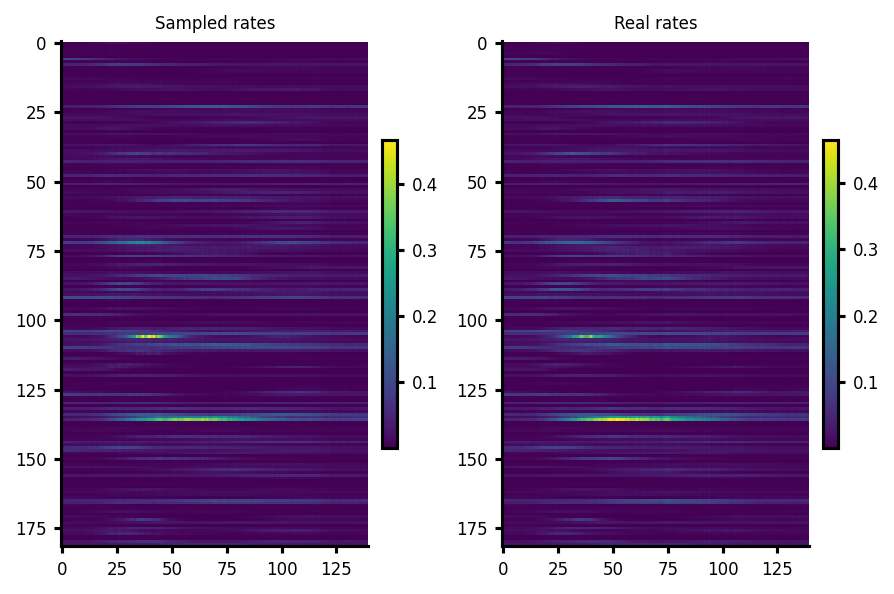

In [12]:
# plot comparison of sampled vs real neural rates

# sample latents conditioned on behavior
sampled_latents = sample_with_velocity(
    ema_denoiser=ema_model,
    scheduler=scheduler,
    cfg=cfg,
    behavior_vel=latent_dataset_train.behavior[:2],  # use first 2 examples
    batch_size=2,
    device="cuda",
)

# unnormalize sampled latents
sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
    sampled_latents.device
) + latent_dataset_train.latent_means.to(sampled_latents.device)

# get real latents for comparison
real_latents = latent_dataset_train.latents[:2].cuda()
real_latents = real_latents * latent_dataset_train.latent_stds.to(
    real_latents.device
) + latent_dataset_train.latent_means.to(real_latents.device)

# decode both latents to rates
with torch.no_grad():
    sampled_rates = ae_model.decode(sampled_latents).cpu()
    decoded_rates_from_real_latents = ae_model.decode(real_latents).cpu()

# plot rates side by side
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
im = ax[0].imshow(sampled_rates[0], aspect="auto")
ax[0].set_title("Sampled rates")
fig.colorbar(im, ax=ax[0], orientation="vertical", fraction=0.046, pad=0.04)

im = ax[1].imshow(decoded_rates_from_real_latents[0], aspect="auto")
ax[1].set_title("Real rates")
fig.colorbar(im, ax=ax[1], orientation="vertical", fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()


In [25]:
import torch
from einops import rearrange, repeat
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score


def train_ridge_regression(train_rates, train_behavior, alpha=1e-6):
    """Train a ridge regression model to predict behavior from neural rates.

    Args:
        train_rates: Neural firing rates tensor [batch, channels, length]
        train_behavior: Behavior tensor [batch, 2, length]
        alpha: L2 regularization strength

    Returns:
        Trained ridge regression model
    """
    # reshape and convert to numpy
    train_rates = rearrange(train_rates, "b c l -> (b l) c").numpy()
    train_behavior = rearrange(train_behavior, "b c l -> (b l) c").numpy()

    # train ridge regression
    ridge_regression_model = Ridge(alpha=alpha)
    ridge_regression_model.fit(train_rates, train_behavior)

    return ridge_regression_model


def evaluate_ridge_regression(ridge_regression_model, val_rates, val_behavior):
    """Evaluate ridge regression model on validation data.

    Args:
        ridge_regression_model: Trained ridge regression model
        val_rates: Validation neural rates tensor [batch, channels, length]
        val_behavior: Validation behavior tensor [batch, 2, length]

    Returns:
        Dict containing predicted and real validation behaviors
    """
    # reshape and convert to numpy
    bs_val = val_rates.shape[0]
    val_rates = rearrange(val_rates, "b c l -> (b l) c").numpy()
    val_behavior = rearrange(val_behavior, "b c l -> (b l) c").numpy()

    # predict behavior using ridge regression model
    predicted_behavior = ridge_regression_model.predict(val_rates)

    # calculate r2 score
    r2 = r2_score(val_behavior, predicted_behavior)
    print(f"r2 score on val: {r2:.3f}")

    return {
        "predicted_val_behavior": rearrange(predicted_behavior, "(b l) c -> b c l", b=bs_val),
        "real_val_behavior": rearrange(val_behavior, "(b l) c -> b c l", b=bs_val),
    }


def gen_rates_and_train_decoded_behavior(
    ema_denoiser,
    scheduler,
    ae,
    cfg,
    train_latent_dataloader,
    val_latent_dataloader,
    num_samples=100,
    device="cuda",
    num_samples_per_batch=1,
    test_velocity=None,
):
    """Generate neural rates and train a decoder to predict behavior.

    Args:
        ema_denoiser: EMA model for denoising
        scheduler: Noise scheduler
        ae: Autoencoder model
        cfg: Config object
        train_latent_dataloader: Training data loader
        val_latent_dataloader: Validation data loader
        num_samples: Number of samples to generate
        device: Device to run on
        num_samples_per_batch: Number of samples per batch
        test_velocity: Optional test velocity to condition on

    Returns:
        Dict containing evaluation results and samples
    """
    avg_denoiser = ema_denoiser.averaged_model
    avg_denoiser.eval()
    ae.eval()

    train_rates = []
    train_behavior = []
    for batch in train_latent_dataloader:
        signal = batch["signal"]
        behavior = batch["behavior"]
        with torch.no_grad():
            output_rates = ae(signal)[0].cpu()
        train_rates.append(output_rates)
        train_behavior.append(behavior.cpu())

    train_rates = torch.cat(train_rates, 0)  # [b c l]
    train_behavior = torch.cat(train_behavior, 0)  # [b 2 l]
    print(train_rates, train_behavior)

    val_rates = []
    val_behavior = []
    for batch in val_latent_dataloader:
        signal = batch["signal"]
        behavior = batch["behavior"]
        with torch.no_grad():
            output_rates = ae(signal)[0].cpu()
        val_rates.append(output_rates)
        val_behavior.append(behavior.cpu())

    val_rates = torch.cat(val_rates, 0)  # [b c l]
    val_behavior = torch.cat(val_behavior, 0)  # [b 2 l]
    print(val_rates, val_behavior)

    # train ridge regression model on training data
    ridge_regression_model = train_ridge_regression(train_rates, train_behavior)

    # evaluate ridge regression model on validation data
    evaluation_results = evaluate_ridge_regression(ridge_regression_model, val_rates, val_behavior)

    # sample from the denoiser
    print(val_latent_dataloader.dataset.behavior[:num_samples].shape)
    if num_samples > len(val_latent_dataloader.dataset.behavior):
        num_samples = len(val_latent_dataloader.dataset.behavior)

    sampled_latents = sample_with_velocity(
        ema_denoiser=ema_denoiser,
        scheduler=scheduler,
        cfg=cfg,
        batch_size=num_samples * num_samples_per_batch,
        behavior_vel=repeat(
            val_latent_dataloader.dataset.behavior[:num_samples],
            "B C L -> (S B) C L",
            S=num_samples_per_batch,
        ),
        device=device,
    )
    print(sampled_latents.shape)
    sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
        sampled_latents.device
    ) + latent_dataset_train.latent_means.to(sampled_latents.device)

    with torch.no_grad():
        sampled_rates = ae.decode(sampled_latents).cpu()
    sampled_latents = (
        rearrange(sampled_latents, "(s b) c l -> s b c l", s=num_samples_per_batch, b=num_samples).cpu().numpy()
    )
    evaluation_results["sampled_latents"] = sampled_latents

    sampled_rates = rearrange(sampled_rates, "(s b) c l -> (s b l) c", s=num_samples_per_batch).numpy()
    predicted_sampled_behavior = ridge_regression_model.predict(sampled_rates)
    predicted_sampled_behavior = rearrange(
        predicted_sampled_behavior, "(s b l) c -> s b c l", b=num_samples, s=num_samples_per_batch
    )
    sampled_rates = rearrange(sampled_rates, "(s b l) c -> s b c l", b=num_samples, s=num_samples_per_batch)
    evaluation_results["sampled_rates"] = sampled_rates

    target_sampled_behavior = val_latent_dataloader.dataset.behavior[:num_samples].cpu().numpy()
    evaluation_results["sampled_behavior"] = predicted_sampled_behavior
    evaluation_results["real_behavior"] = val_latent_dataloader.dataset.behavior[:num_samples].cpu().numpy()
    evaluation_results["decoded_latents"] = val_latent_dataloader.dataset.latents[:num_samples].cpu().numpy()

    return evaluation_results

In [26]:
ret_dict = gen_rates_and_train_decoded_behavior(
    ema_denoiser=ema_model,
    scheduler=scheduler,
    ae=ae_model,
    cfg=cfg,
    train_latent_dataloader=train_latent_dataloader,
    val_latent_dataloader=test_latent_dataloader,
    num_samples=100,
    device="cuda",
    num_samples_per_batch=5,
)

tensor[2008, 182, 140] n=51163840 (0.2Gb) x∈[2.045e-06, 0.890] μ=0.019 σ=0.029 tensor[2008, 2, 140] n=562240 (2.1Mb) x∈[-1.154, 1.215] μ=0.016 σ=0.274
tensor[216, 182, 140] n=5503680 (21Mb) x∈[2.458e-06, 0.802] μ=0.019 σ=0.029 tensor[216, 2, 140] n=60480 (0.2Mb) x∈[-1.017, 1.263] μ=0.015 σ=0.279
r2 score on val: 0.882
torch.Size([100, 2, 140])


/mnt/lustre/work/macke/jkapoor83/conda_envs_dirs/ldns/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.34914e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([500, 16, 140])


In [15]:
# sanity check of shapes

predicted_traj = np.cumsum(ret_dict["predicted_val_behavior"], axis=-1)
real_traj = np.cumsum(ret_dict["real_behavior"], axis=-1)
sampled_traj = np.cumsum(ret_dict["sampled_behavior"], axis=-1)

print(predicted_traj.shape, real_traj.shape, sampled_traj.shape)


(71, 2, 140) (71, 2, 140) (5, 71, 2, 140)


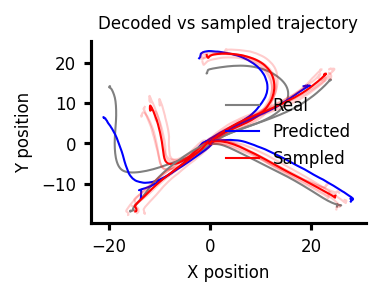

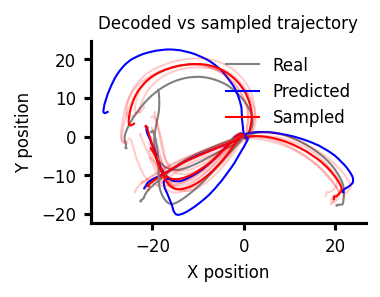

In [16]:
# plot real vs predicted vs sampled trajectories
from matplotlib.lines import Line2D

# plot trajectories in batches of 5
for i_b_i, b_i in enumerate(range(0, 70, 7)):
    # create new figure for each batch of 5
    if i_b_i % 5 == 0:
        plt.figure(figsize=cm2inch(6, 4))

    # plot real trajectory
    plt.plot(real_traj[b_i, 0], real_traj[b_i, 1], color="grey", linestyle="-")
    # plot predicted trajectory
    plt.plot(predicted_traj[b_i, 0], predicted_traj[b_i, 1], color="blue")
    # plot mean sampled trajectory
    plt.plot(sampled_traj.mean(0)[b_i, 0], sampled_traj.mean(0)[b_i, 1], color="red", linestyle="-")
    # plot individual sampled trajectories with transparency
    for i in range(len(sampled_traj)):
        plt.plot(sampled_traj[i, b_i, 0], sampled_traj[i, b_i, 1], color="red", alpha=0.2)

    # add labels and legend after every 5 trajectories
    if i_b_i % 5 == 4:
        plt.xlabel("X position")
        plt.ylabel("Y position")
        legend_elements = [
            Line2D([0], [0], color="grey", linestyle="-", label="Real"),
            Line2D([0], [0], color="blue", linestyle="-", label="Predicted"),
            Line2D([0], [0], color="red", linestyle="-", label="Sampled"),
        ]
        plt.legend(handles=legend_elements)
        plt.title("Decoded vs sampled trajectory")
        plt.show()


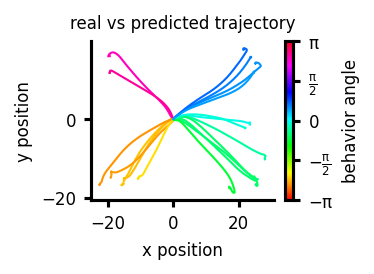

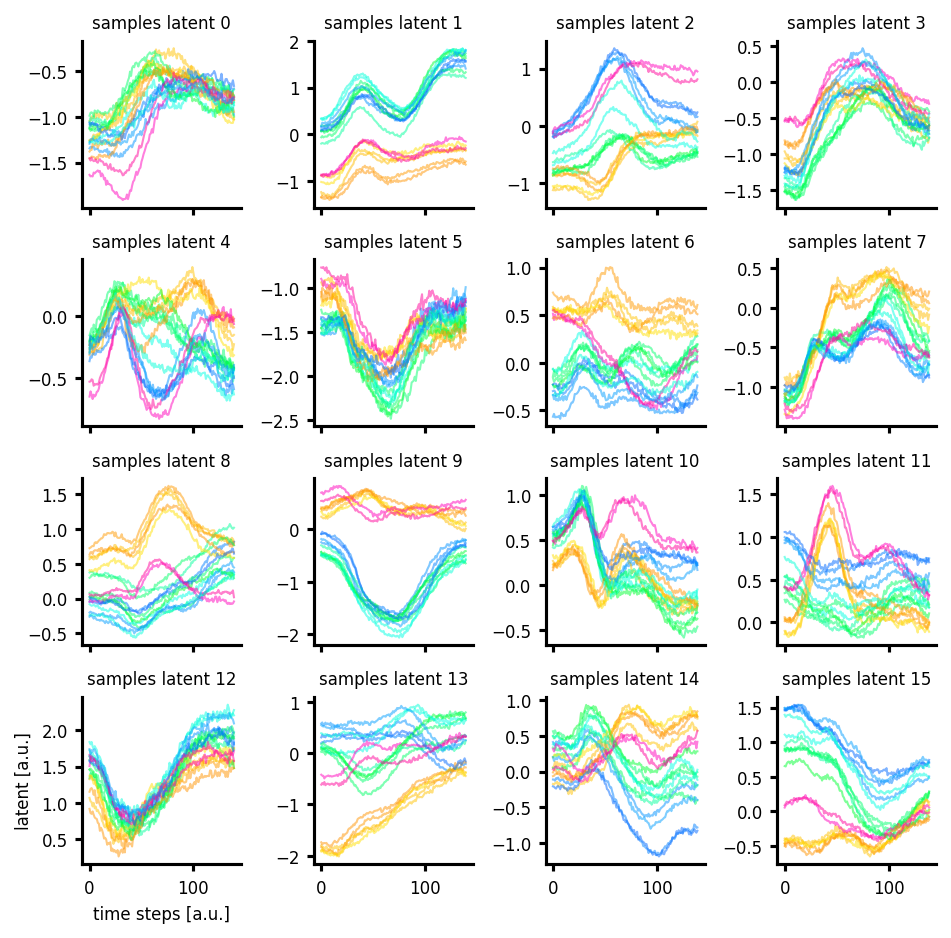

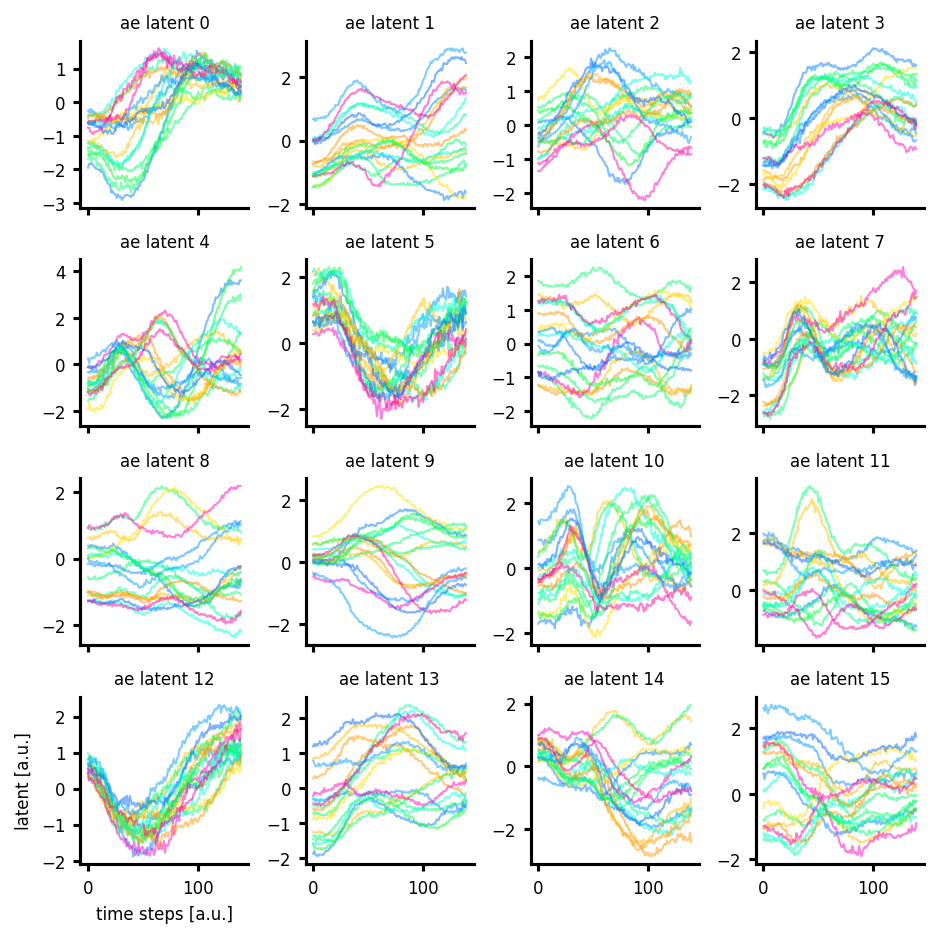

In [17]:
# get reach angles and find straight reaches
angle_real_val_behavior = np.arctan2(real_traj[:, 1, -1], real_traj[:, 0, -1])
angle_real_val_behavior_init = np.arctan2(real_traj[:, 1, 50], real_traj[:, 0, 50])
straight_indices_predicted = np.where(np.abs(angle_real_val_behavior_init - angle_real_val_behavior) < 0.3)[0]

# plot trajectories colored by angle
plt.figure(figsize=cm2inch(5, 3.5))
for idx in straight_indices_predicted:
    plt.plot(
        real_traj[idx, 0, :],
        real_traj[idx, 1, :],
        color=angle_to_color(angle_real_val_behavior[idx]),
    )
plt.xlabel("x position")
plt.ylabel("y position")
plt.title("real vs predicted trajectory")

# add colorbar
cmap = plt.get_cmap("hsv")
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(-np.pi, np.pi))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(-np.pi, np.pi, 5), label="behavior angle", ax=plt.gca())
cbar.ax.set_yticklabels([r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])

# plot sampled latents
fig, ax = plt.subplots(4, 4, figsize=cm2inch(16, 16), sharex=True)
ax = ax.flatten()

sampled_latents_reshaped = rearrange(ret_dict["sampled_latents"], "(S B) C L -> S B C L", S=5).cpu().numpy()
for idx in straight_indices_predicted:
    for i in range(16):
        ax[i].plot(
            sampled_latents_reshaped[0, idx, i, :].T,
            c=angle_to_color(angle_real_val_behavior[idx]),
            alpha=0.5,
        )
        ax[i].set_title(f"samples latent {i}")
ax[-4].set_ylabel("latent [a.u.]")
ax[-4].set_xlabel("time steps [a.u.]")
plt.tight_layout()

# plot ae latents
fig, ax = plt.subplots(4, 4, figsize=cm2inch(16, 16), sharex=True)
ax = ax.flatten()
for idx in straight_indices_predicted:
    for i in range(16):
        ax[i].plot(
            test_latent_dataloader.dataset.latents.cpu().numpy()[idx, i, :].T,
            c=angle_to_color(angle_real_val_behavior[idx]),
            alpha=0.5,
        )
        ax[i].set_title(f"ae latent {i}")
ax[-4].set_ylabel("latent [a.u.]")
ax[-4].set_xlabel("time steps [a.u.]")
plt.tight_layout()


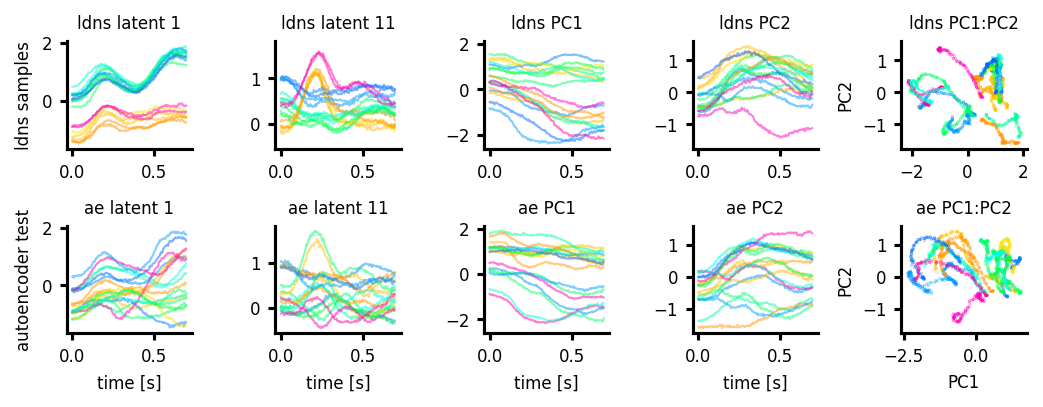

In [24]:
# plot latents and PCA analysis of sampled vs real data
from sklearn.decomposition import PCA

# setup time array
fps = 1000 / 5
time_steps = len(real_traj[0, 0, :])
time_array = np.arange(0, time_steps, 1) / fps

# get test data encoded to latents and standardize like samples
data_decoded = test_latent_dataloader.dataset.latents.cpu().numpy()
data_decoded = (
    data_decoded * latent_dataset_train.latent_stds.cpu().numpy() + latent_dataset_train.latent_means.cpu().numpy()
)

# create composite figure comparing latents and PCA
fig_composite, ax_composite = plt.subplots(2, 5, figsize=cm2inch(18, 7), sharey="col")

# plot selected latent dimensions
for idx in straight_indices_predicted:
    for i, lat in enumerate([1, 11]):
        # plot autoencoder latents
        ax_composite[1, i].plot(
            time_array,
            data_decoded[idx, lat, :].T,
            c=angle_to_color(angle_real_val_behavior[idx]),
            alpha=0.5,
        )
        ax_composite[1, i].set_title(f"ae latent {lat}")
        ax_composite[1, i].set_xlabel("time [s]")

        # plot sampled latents
        ax_composite[0, i].plot(
            time_array,
            ret_dict["sampled_latents"][idx, lat, :].T.cpu(),
            c=angle_to_color(angle_real_val_behavior[idx]),
            alpha=0.5,
        )
        ax_composite[0, i].set_title(f"ldns latent {lat}")

# PCA on sampled data
data = ret_dict["sampled_latents"][::5].cpu().numpy()
n_samples, n_latents, time_steps = data.shape
data_reshaped = data.transpose(0, 2, 1).reshape(-1, n_latents)

# fit PCA on sampled data
pca = PCA(n_components=5)
pca_result = pca.fit_transform(data_reshaped)
pca_result_reshaped = pca_result.reshape(n_samples, time_steps, 5).transpose(0, 2, 1)

# plot first two PCs of sampled data
for i in range(2):
    for idx in straight_indices_predicted:
        ax_composite[1, i + 2].plot(
            time_array, pca_result_reshaped[idx, i, :], alpha=0.5, color=angle_to_color(angle_real_val_behavior[idx])
        )
    ax_composite[0, i + 2].set_title(f"ldns PC{i+1}")
    ax_composite[1, i + 2].set_xlabel("time [s]")

# plot PC1 vs PC2 trajectory for sampled data
for idx in straight_indices_predicted:
    ax_composite[0, -1].plot(
        pca_result_reshaped[idx, 0, :],
        pca_result_reshaped[idx, 1, :],
        ".",
        ms=0.5,
        alpha=0.6,
        color=angle_to_color(angle_real_val_behavior[idx]),
    )
ax_composite[0, -1].set_title("ldns PC1:PC2")
ax_composite[0, -1].set_ylabel("PC2")

# PCA on real data using same transformation
data = data_decoded
n_samples, n_latents, time_steps = data.shape
data_reshaped = data.transpose(0, 2, 1).reshape(-1, n_latents)
pca_result = pca.transform(data_reshaped)
pca_result_reshaped = pca_result.reshape(n_samples, time_steps, 5).transpose(0, 2, 1)

# plot first two PCs of real data
for i in range(2):
    for idx in straight_indices_predicted:
        ax_composite[0, i + 2].plot(
            time_array, pca_result_reshaped[idx, i, :], alpha=0.5, color=angle_to_color(angle_real_val_behavior[idx])
        )
    ax_composite[1, i + 2].set_title(f"ae PC{i+1}")
    ax_composite[1, i + 2].set_xlabel("time [s]")

# plot PC1 vs PC2 trajectory for real data
for idx in straight_indices_predicted:
    ax_composite[1, -1].plot(
        pca_result_reshaped[idx, 0, :],
        pca_result_reshaped[idx, 1, :],
        ".",
        ms=0.5,
        alpha=0.6,
        color=angle_to_color(angle_real_val_behavior[idx]),
    )
ax_composite[1, -1].set_title("ae PC1:PC2")
ax_composite[1, -1].set_ylabel("PC2")
ax_composite[1, -1].set_xlabel("PC1")

# add row labels
ax_composite[0, 0].set_ylabel("ldns samples")
ax_composite[1, 0].set_ylabel("autoencoder test")

plt.tight_layout()
